In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
import sklearn.model_selection

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

In [19]:
boston = load_boston()


# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)



In [23]:
X_DATA = X_bos_pd[["CRIM","AGE"]].head(50)
Y_DATA = Y_bos_pd.head(50)

In [24]:
X_DATA

,CRIM,AGE
0,0.00632,65.2
1,0.02731,78.9
2,0.02729,61.1
3,0.03237,45.8
4,0.06905,54.2
5,0.02985,58.7
6,0.08829,66.6
7,0.14455,96.1
8,0.21124,100.0
9,0.17004,85.9


In [25]:
# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_DATA, Y_DATA, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

In [27]:
X_train

,CRIM,AGE
9,0.17004,85.9
24,0.75026,94.1
40,0.03359,15.8
38,0.17505,30.2
35,0.06417,68.2
26,0.67191,90.3
1,0.02731,78.9
7,0.14455,96.1
34,1.61282,96.9
39,0.02763,21.8


In [28]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [29]:
prefix = 'boston-xgboost-HL-tutorial-2'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [30]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [31]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

In [32]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-09 08:27:31 Starting - Starting the training job...
2020-09-09 08:27:32 Starting - Launching requested ML instances......
2020-09-09 08:28:38 Starting - Preparing the instances for training...
2020-09-09 08:29:27 Downloading - Downloading input data...
2020-09-09 08:29:46 Training - Downloading the training image..Arguments: train
[2020-09-09:08:30:07:INFO] Running standalone xgboost training.
[2020-09-09:08:30:07:INFO] File size need to be processed in the node: 0.0mb. Available memory size in the node: 8472.68mb
[2020-09-09:08:30:07:INFO] Determined delimiter of CSV input is ','
[08:30:07] S3DistributionType set as FullyReplicated
[08:30:07] 22x2 matrix with 44 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-09-09:08:30:07:INFO] Determined delimiter of CSV input is ','
[08:30:07] S3DistributionType set as FullyReplicated
[08:30:07] 11x2 matrix with 22 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter

In [33]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


...........................
.2020-09-09T08:35:10.431:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
Arguments: serve
[2020-09-09 08:35:10 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-09-09 08:35:10 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-09-09 08:35:10 +0000] [1] [INFO] Using worker: gevent
[2020-09-09 08:35:10 +0000] [37] [INFO] Booting worker with pid: 37
[2020-09-09 08:35:10 +0000] [38] [INFO] Booting worker with pid: 38
[2020-09-09:08:35:10:INFO] Model loaded successfully for worker : 37
[2020-09-09 08:35:10 +0000] [39] [INFO] Booting worker with pid: 39
[2020-09-09:08:35:10:INFO] Model loaded successfully for worker : 38
[2020-09-09:08:35:10:INFO] Sniff delimiter as ','
[2020-09-09:08:35:10:INFO] Determined delimiter of CSV input is ','
[2020-09-09 08:35:10 +0000] [40] [INFO] Booting worker with pid: 40
[2020-09-09:08:35:10:INFO] Model loaded successfully for worker : 39
[2020-09-09:08:35:10:INFO] Model loaded su

In [34]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-2-360760555806/xgboost-2020-09-09-08-30-43-034/test.csv.out to ../data/boston/test.csv.out


Text(0.5, 1.0, 'Median Price vs Predicted Price')

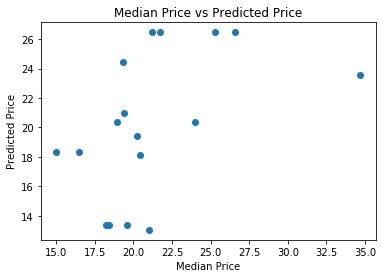

In [35]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

In [37]:
Y_pred

,0
0,13.048460
1,18.125729
2,19.428564
3,20.373516
4,13.348756
5,24.437555
6,26.453323
7,13.348756
8,20.993769
9,13.348756


In [38]:
df = Y_test.rename(columns={'newName1': 'test'}).reset_index(drop=True)

df["predict"] = Y_pred

df

,0,predict
0,21.0,13.048460
1,20.4,18.125729
2,20.2,19.428564
3,24.0,20.373516
4,19.6,13.348756
5,19.3,24.437555
6,21.2,26.453323
7,18.4,13.348756
8,19.4,20.993769
9,18.2,13.348756


In [39]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(Y_test, Y_pred))

rms

4.800511646997764

In [40]:
from sklearn.metrics import mean_absolute_error as MAE

mae_result = MAE(Y_test, Y_pred)

mae_result

3.920303109111764

In [41]:
from sklearn.metrics import r2_score

scipy_value = r2_score(Y_test, Y_pred)

scipy_value

-0.1869463286685451

In [139]:
import numpy

y = [1, 2, 3, 4, 5]
f = [1.9, 3.7, 5.8, 8.0, 9.6]

# Convert to numpy array and ensure double precision to avoid single precision errors
observed = numpy.array(y, dtype=numpy.float64)
predicted = numpy.array(f, dtype=numpy.float64)

observed

array([1., 2., 3., 4., 5.])

In [140]:
y

[1, 2, 3, 4, 5]

In [143]:
df["test"]

0      21.8
1      25.0
2       5.6
3      23.7
4       6.3
       ... 
162    19.5
163    23.6
164    27.1
165    19.4
166    16.1
Name: test, Length: 167, dtype: float64